 # Spotify API And Data Analysis Personal Project

 ## Project Introduction

This project explores how Spotify metrics relate to the real-world success of newly released albums.
Using data collected directly from the Spotify Web API, the analysis examines whether long-term fanbase size, short-term artist momentum, or internal album structure can meaningfully explain why some albums perform better than others.

The project is divided into three analytical stages:

1. **Followers vs. Performance**

We begin by testing a common assumption:
Do artists with more followers release more successful albums?
By comparing follower count to both album popularity and artist popularity, we show that follower numbers - a long-term, historical metric - do not reliably predict the performance of a new album.

2. **Artist Popularity vs. Album Popularity**

Next, we investigate the correlation between an  artist's overall popularity score, to it's latest album popularity.
Here we find that Spotify’s Artist Popularity score, which reflects recent listening activity and short-term momentum, shows a clear and consistent alignment with new album performance.
This holds both with and without outliers (e.g. Taylor Swift), indicating a true underlying pattern.

3. **Case Study: Lily Allen’s New Album**

After establishing general trends, we zoom into a concrete example.
Using several statistical measures - mean popularity, the range of popularity within the album, and the ration between the success of the release to the overall performance of the artist - we show that Lily Allen’s latest release is not only successful overall, but also exceptionally consistent, with the tightest track-level popularity distribution in the dataset.
This makes her album one of the strongest and most uniformly performing projects in the entire sample.

### Summary

This project combines API data retrieval and exploratory data analysis to uncover meaningful insights into what drives album success on Spotify.
By separating long-term fanbase indicators from real-time listening momentum and examining track-level structure, we gain a clearer understanding of how modern album performance behaves in the streaming era.

In [454]:
#import libraries

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


#### Part I - Accessing the Spotify API, Creating the Desired DataFrame

The first stage of any API-based project is registering for the platform’s developer API and retrieving the required authentication credentials.
In this project, I obtained my Client ID and Client Secret through Spotify’s Developer Dashboard using my personal account.

For security reasons, these credentials are censored in this notebook.
If you wish to run the code yourself, please generate your own API keys and replace the placeholders with your personal credentials.

In [ ]:
# get token & headers

CLIENT_ID = "***********"
CLIENT_SECRET = "************"

auth_url = "https://accounts.spotify.com/api/token"
resp = requests.post(auth_url, data={
    "grant_type": "client_credentials",
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET
})
access_token = resp.json()["access_token"]
headers = {"Authorization": f"Bearer {access_token}"}

#### Second Step - Using API Requests to Retrieve Data and Build a DataFrame

Retrieving the relevant data through API requests was done using the following workflow:

1. Request the album by artist name to obtain the album’s unique Album ID.
2. Use the Album ID to request the list of tracks and extract their Track IDs.
3. Retrieve detailed track information (including popularity metrics) using each Track ID.
4. Compile all retrieved data into a structured DataFrame for further analysis.

To streamline this process, we implemented a function that performs all of the above steps for a single album.



In [456]:
# build a function for extracting one album info

def get_album_df(artist_name, album_name, headers, base_url = "https://api.spotify.com/v1"):

# the function gets an artist and an album and returns a df with all the tracks in the album and their popularity rank as published in Spotify API
   # step one: get album id

   search_url = f"{base_url}/search"
   query = f'album:"{album_name}" artist:"{artist_name}"'
   params = {
    "q": query,
    "type": "album",
    "limit": 1
    }
   
   r = requests.get(search_url, headers=headers, params=params)
   r.raise_for_status()
   data = r.json()

   albums = data["albums"]["items"]
   album_id = albums[0]["id"]

   # step two: get track ids

   tracks_url = f"{base_url}/albums/{album_id}/tracks"
   params = {"limit": 50}
   r = requests.get(tracks_url, headers=headers,params=params)
   r.raise_for_status()
   tracks = r.json()["items"]

   track_ids = [t["id"] for t in tracks]

   # step three: get tracks details 

   url = f"{base_url}/tracks"
   params = {"ids": ",".join(track_ids)}

   r = requests.get(url, headers=headers, params=params)
   r.raise_for_status()

   details = r.json()["tracks"]
   
   # step four: build the df

   rows = []

   for d in details:
    rows.append({
        "track_name": d["name"],
        "track_number": d["track_number"],
        "duration_ms": d["duration_ms"],
        "explicit": d["explicit"],
        "artists": ", ".join(a["name"] for a in d["artists"]),
        "album": d["album"]["name"],
        "album_release_date": albums[0]["release_date"],
        "popularity": d["popularity"]       
    })

   df = pd.DataFrame(rows)

   #output the df

   return df


In [457]:
# try one album for verification

get_album_df("Lily Allen", "West End Girl", headers, base_url = "https://api.spotify.com/v1").head()

,track_name,track_number,duration_ms,explicit,artists,album,album_release_date,popularity
0,West End Girl,1,246293,False,Lily Allen,West End Girl,2025-10-24,76
1,Ruminating,2,206800,True,Lily Allen,West End Girl,2025-10-24,74
2,Sleepwalking,3,177106,True,Lily Allen,West End Girl,2025-10-24,75
3,Tennis,4,150733,True,Lily Allen,West End Girl,2025-10-24,76
4,Madeline,5,175413,True,Lily Allen,West End Girl,2025-10-24,76


Next, we define a function that takes a list of albums and applies the single-album extraction function to each one, combining all results into a single unified DataFrame.

In [458]:
# build a function for creating a df with multiple albums

def get_album_dfs(albums, headers, base_url = "https://api.spotify.com/v1"):
    
    # the function gets a list of albums and returns a df containing the tracks from all the albums and their popularity rank

    all_dfs = []
    for artist_name, album_name in albums:
        print(f"Downloading Album: {album_name} by {artist_name}")
        df_album = get_album_df(artist_name, album_name, headers)
        all_dfs.append(df_album)

    if not all_dfs:
        return pd.DataFrame()
    
    return pd.concat(all_dfs, ignore_index=True)

After retrieving all album-level information and popularity metrics, we use the Spotify API to collect additional artist-level features:

 - Number of followers on Spotify
 - Overall Artist Popularity score (Spotify’s global momentum metric)

The following function generates a single-row DataFrame containing these attributes for any artist of interest.

In [459]:
# build a function that retrieves artists features and information

def artist_info(artist, headers, base_url = "https://api.spotify.com/v1"):
    
   search_url = f"{base_url}/search"
   params = {
    "q": f"{artist}",
    "type": "artist",
    "limit": 3
    }
   
   r = requests.get(search_url, headers=headers, params=params)
   r.raise_for_status()
   artist = r.json()["artists"]["items"]

   row = {
      "artist": artist[0]["name"],
      "followers": artist[0]["followers"]["total"],
      "artist_popularity": artist[0]["popularity"]
   }

   art_df = pd.DataFrame([row])

   return art_df


In [460]:
# Try one artist

artist_info("RAYE", headers)

,artist,followers,artist_popularity
0,RAYE,3124931,84


Similarly to the album DataFrame, we combine information from multiple artists into a single unified DataFrame using the following function:

In [461]:
# Write a function that joins all the artists into one df

def artists_info(artists, headers, base_url = "https://api.spotify.com/v1"):

    all_art = []
    for artist_name in artists:
        print(f"Downloading Artist:{artist_name}")
        df_art = artist_info(artist_name, headers)
        all_art.append(df_art)

    if not all_art:
        return pd.DataFrame()
    
    return pd.concat(all_art, ignore_index=True)   

For our analysis, we examine 15 high-profile albums released around the same time period - October to November 2025.
The selection includes artists across a wide popularity spectrum, ranging from global household names like Taylor Swift to more niche acts such as De La Soul.

In [462]:
# create a df with the top releases of Oct-Nov 25

albums_list = [
    ("ROSALIA", "LUX"),
    ("Lily Allen", "West End Girl"),
    ("Tame Impala", "Deadbeat"),
    ("Taylor Swift", "The Life of a Showgirl"),
    ("FKA twigs", "EUSEXUA Afterglow"),
    ("Demi Lovato", "It's Not That Deep"),
    ("Jessie J", "Don't Tease Me with a Good Time"),
    ("De La Soul", "Cabin in the Sky"),
    ("Summer Walker", "Finally Over It"),
    ("Portugal. The Man", "Shish"),
    ("Offset", "Haunted by Fame"),
    ("Daniel Caesar", "Son of Spergy"),
    ("Miguel", "Caos"),
    ("Gucci Mane", "Episodes"),
    ("Khalid", "After the Sun Goes Down")
] 

albums_df = get_album_dfs(albums_list, headers)

# create a new column with artist and album name combined
albums_df["artist_album"] = albums_df["artists"].str.split(",").str[0] + "--" + albums_df["album"]
albums_df.head()

,track_name,track_number,duration_ms,explicit,artists,album,album_release_date,popularity,artist_album
0,"Sexo, Violencia y Llantas",1,140760,False,ROSALÍA,LUX,2025-11-07,85,ROSALÍA--LUX
1,Reliquia,2,230240,False,ROSALÍA,LUX,2025-11-07,87,ROSALÍA--LUX
2,Divinize,3,243240,False,ROSALÍA,LUX,2025-11-07,84,ROSALÍA--LUX
3,Porcelana,4,248093,False,"ROSALÍA, Dougie F",LUX,2025-11-07,83,ROSALÍA--LUX
4,Mio Cristo Piange Diamanti,5,269680,False,ROSALÍA,LUX,2025-11-07,82,ROSALÍA--LUX


In [463]:
#Create the artist info data set
art_info = artists_info([pair[0] for pair in albums_list], headers)
art_info.head()

,artist,followers,artist_popularity
0,ROSALÍA,9111978,89
1,Lily Allen,2293747,78
2,Tame Impala,9823086,86
3,Taylor Swift,147935844,100
4,FKA twigs,1475454,70


Now that we created an Album DataFrame and an Artist DataFrame, we wish to calculate additional statistical features which will be used for data analysis next.

The aggregated features we retrieve:
1. **pop_avg** - the mean popularity score for the album
2. **max_pop_song** - maximum popularity for a song in the album
3. **min_pop_song** - minimum popularity for a song in the album

Additionally, we calculate the following features:
1. **range** - $\max_{\text{popularity in album}} - \min_{\text{popularity in album}}$
2. **range_div_mean** - $\frac{\text{Range}}{\text{Mean}}$

Finally, we merge all the information together to create one aggregated DataFrame with one row for each album, holding all the data relevant for our analysis. 

In [464]:
#Create the final df where we combine aggregated features and available artists features

#aggregated features:
avg_pop = albums_df.groupby(
    ["artist_album", "album", "album_release_date"]
).agg(
    pop_avg = ("popularity", "mean"), #mean popularity of the album
    max_pop_song = ("popularity", "max"), #popularity of the top song in the album
    min_pop_song = ("popularity", "min") #popularity of the bottom song in the album
    ).sort_values("album_release_date").reset_index()

#add an artist column
avg_pop["artist"] = avg_pop["artist_album"].str.split("--").str[0]

#combine both dfs:
art_df = pd.merge(avg_pop, art_info, on = "artist").sort_values("followers", ascending = False)

#Calculate new features:
art_df["followers_in_mil"] = art_df["followers"]/1e6 #Followers in millions 
art_df["range"] = art_df["max_pop_song"] - art_df["min_pop_song"] #Popularity range - MAX minus MIN
art_df["range_div_mean"] = art_df["range"] / art_df["pop_avg"] #range divided by mean popularity - to asses the spread

art_df.head()


,artist_album,album,album_release_date,pop_avg,max_pop_song,min_pop_song,artist,followers,artist_popularity,followers_in_mil,range,range_div_mean
0,Taylor Swift--The Life of a Showgirl,The Life of a Showgirl,2025-10-03,89.833333,100,86,Taylor Swift,147935844,100,147.935844,14,0.155844
6,Demi Lovato--It’s Not That Deep,It’s Not That Deep,2025-10-24,64.181818,73,60,Demi Lovato,27300608,79,27.300608,13,0.202550
1,Khalid--after the sun goes down,after the sun goes down,2025-10-10,56.750000,63,51,Khalid,17026148,83,17.026148,12,0.211454
14,Jessie J--Don't Tease Me With A Good Time,Don't Tease Me With A Good Time,2025-11-28,48.875000,63,46,Jessie J,12250963,74,12.250963,17,0.347826
5,Daniel Caesar--Son Of Spergy,Son Of Spergy,2025-10-24,71.583333,87,66,Daniel Caesar,11839704,88,11.839704,21,0.293364


#### Part II - Exploratory Data Analysis 

Now that we have constructed our full dataset, we proceed to explore the key features that may contribute to the success of a newly released album.

Spotify provides several popularity-related metrics, each capturing a different aspect of how listeners engage with an artist or a track.

**Track Popularity** reflects the recent performance of an individual song and is driven primarily by the number of plays and engagement it receives within a short time window. This metric is highly dynamic and represents short-term listening behavior.

**Artist Popularity**, in contrast, is a broader momentum metric derived from the aggregated popularity of all tracks in an artist’s catalogue, adjusted for consistency and overall listening patterns. It captures medium-term relevance and how actively listeners engage with the artist at the moment.
Both Track and Artist Popularity scores range from 0 to 100.

Finally, **Follower Count** measures how many users have chosen to follow the artist, representing a long-term historical fanbase rather than current listening activity.

Together, these three metrics provide complementary perspectives - short-term track performance, medium-term artist momentum, and long-term audience size, allowing us to better understand the different dimensions of success in the streaming environment.

##### Analysis of Plots 1-2: Followers vs. Album Popularity

Plots 1 and 2 examine whether an artist’s follower count predicts the success of their latest album.
In Plot 1, which includes Taylor Swift, her enormous follower base overwhelmingly dominates the scale, making it difficult to visually interpret the remaining artists.

When removing Taylor Swift in Plot 2, the distribution becomes much clearer, allowing us to compare the other artists on a more meaningful scale.
However, even after removing this extreme outlier, the key insight remains unchanged:

**Follower count does not correlate with album popularity.**

Artists with millions of followers often release moderately performing albums, while several artists with significantly fewer followers achieve similar or even higher album popularity.
This suggests that follower count - an inherently slow-changing, long-term metric - is not a reliable indicator of how well a new album will perform.

##### Analysis of Plots 3-4: Followers vs. Artist Popularity

Plots 3 and 4 repeat a similar comparison, but this time relate follower count to Artist Popularity, Spotify’s momentum-based metric.
In Plot 3, Taylor Swift again dominates due to her scale, compressing the rest of the data visually. After removing her in Plot 4, the underlying pattern becomes easier to observe.

Here, unlike with album popularity, we do see a loosely positive relationship:
artists with larger follower bases tend to have higher Artist Popularity scores.
This makes sense, as established artists typically maintain steady engagement across their discography.

However, the relationship is still not tight enough to be predictive, reinforcing the idea that:

**Followers reflect historical fanbase size, while Artist Popularity reflects current listener engagement.**

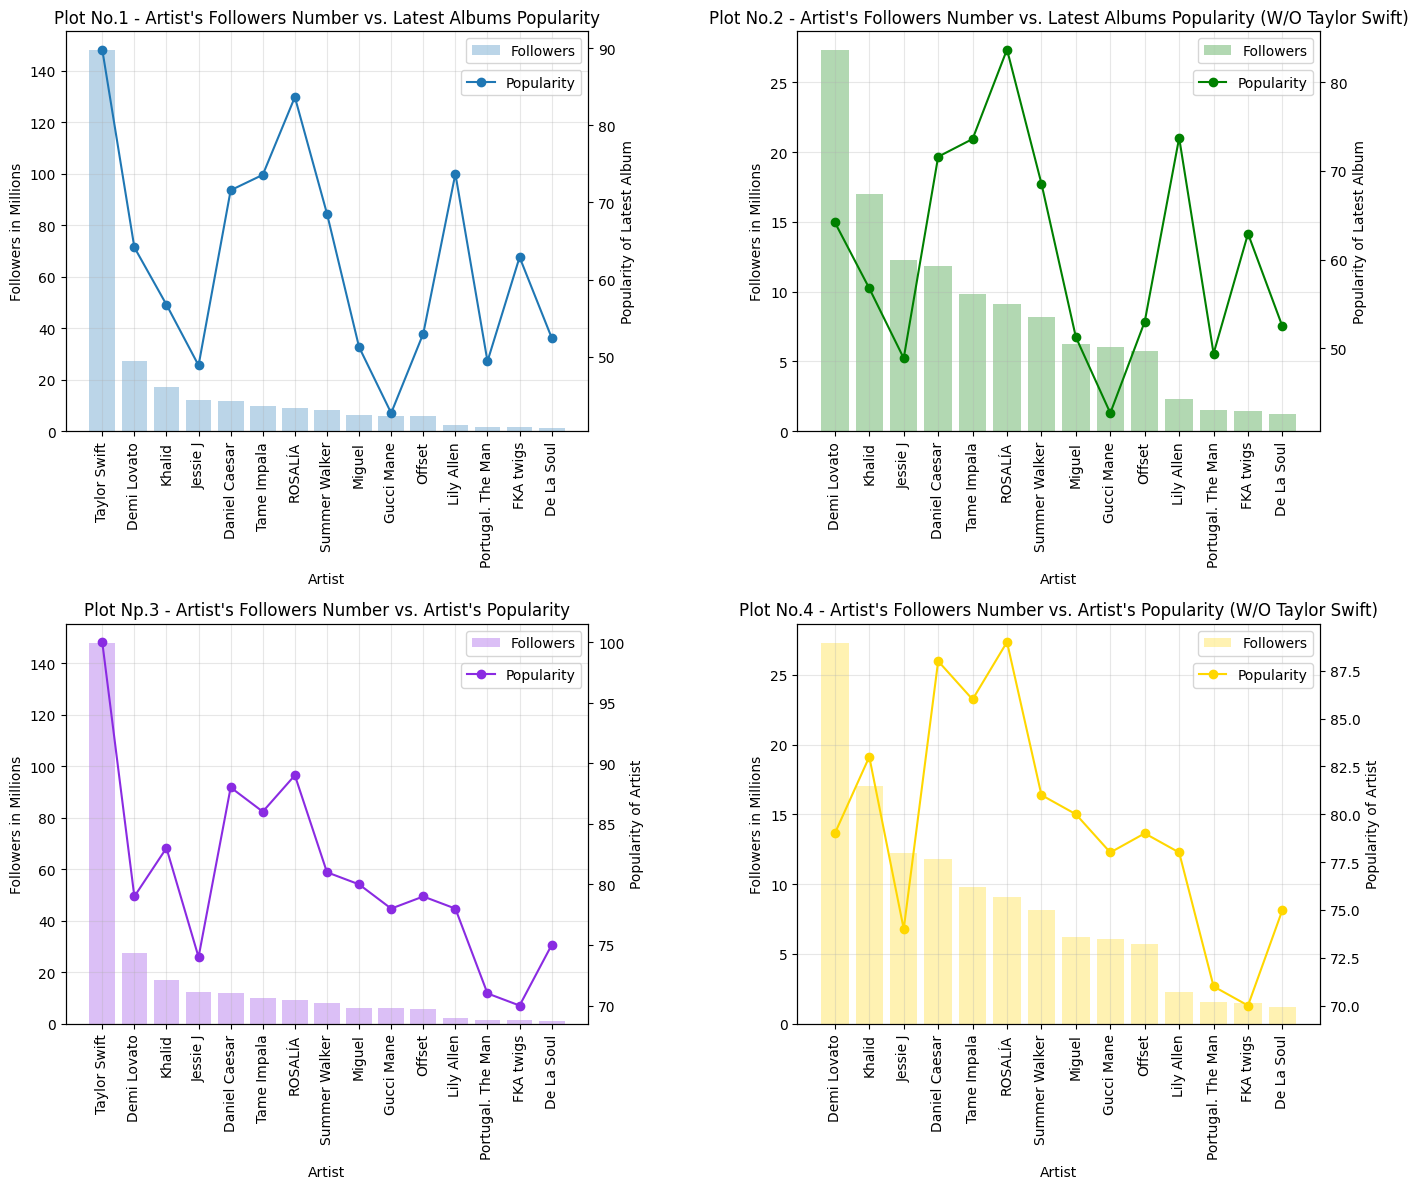

In [465]:
# create plots that compare artists followers numbers to their latest albums popularity

art_df = art_df.sort_values("followers_in_mil", ascending=False)
#create an additional df w/o Taylor Swift since she is on here own league 
filtered = art_df[art_df["artist"] != "Taylor Swift"]

fig, axs = plt.subplots(2,2, figsize=(14,12))

#left plot - with Taylor
ax1 = axs[0,0]
x = art_df["artist"]

ax1.bar(x, art_df["followers_in_mil"], alpha = 0.3, label = "Followers")
ax1.set_xlabel("Artist")
ax1.set_ylabel("Followers in Millions")
ax1.tick_params(axis="x", rotation=90)

ax2 = ax1.twinx()
ax2.plot(x, art_df["pop_avg"], marker = "o", label = "Popularity")
ax2.set_ylabel("Popularity of Latest Album")

axs[0,0].set_title("Plot No.1 - Artist's Followers Number vs. Latest Albums Popularity")
ax1.legend(loc = "best")
ax2.legend(loc = "best", bbox_to_anchor = (1.,0.92))

#right plot - no Taylor
ax3 = axs[0,1]
x2 = filtered["artist"]

ax3.bar(x2,  filtered["followers_in_mil"], alpha = 0.3, color = "green", label = "Followers")
ax3.set_xlabel("Artist")
ax3.set_ylabel("Followers in Millions")
ax3.tick_params(axis="x", rotation=90)

ax4 = ax3.twinx()
ax4.plot(x2, filtered["pop_avg"], marker = "o", color = "green", label = "Popularity")
ax4.set_ylabel("Popularity of Latest Album")

axs[0,1].set_title("Plot No.2 - Artist's Followers Number vs. Latest Albums Popularity (W/O Taylor Swift)")
ax3.legend(loc = "best")
ax4.legend(loc = "best", bbox_to_anchor = (1.,0.92))

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
axs[0,0].grid(alpha = 0.3)
axs[0,1].grid(alpha = 0.3)

#Artist Followers vs Artist Popularity
#left plot - with Taylor
ax5 = axs[1,0]
x3 = art_df["artist"]

ax5.bar(x3, art_df["followers_in_mil"], alpha = 0.3, label = "Followers", color = "blueviolet")
ax5.set_xlabel("Artist")
ax5.set_ylabel("Followers in Millions")
ax5.tick_params(axis="x", rotation=90)

ax6 = ax5.twinx()
ax6.plot(x3, art_df["artist_popularity"], marker = "o", label = "Popularity", color = "blueviolet")
ax6.set_ylabel("Popularity of Artist")

axs[1,0].set_title("Plot Np.3 - Artist's Followers Number vs. Artist's Popularity")
ax5.legend(loc = "best")
ax6.legend(loc = "best", bbox_to_anchor = (1.,0.92))

#right plot - no Taylor
ax7 = axs[1,1]
x4 = filtered["artist"]

ax7.bar(x4,  filtered["followers_in_mil"], alpha = 0.3, color = "gold", label = "Followers")
ax7.set_xlabel("Artist")
ax7.set_ylabel("Followers in Millions")
ax7.tick_params(axis="x", rotation=90)

ax8 = ax7.twinx()
ax8.plot(x4, filtered["artist_popularity"], marker = "o", color = "gold", label = "Popularity")
ax8.set_ylabel("Popularity of Artist")

axs[1,1].set_title("Plot No.4 - Artist's Followers Number vs. Artist's Popularity (W/O Taylor Swift)")
ax7.legend(loc = "best")
ax8.legend(loc = "best", bbox_to_anchor = (1.,0.92))

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
axs[1,0].grid(alpha = 0.3)
axs[1,1].grid(alpha = 0.3)
plt.show()

##### Analysis of Artist vs. Album Popularity (Plots no. 5–6)

Plots no. 5 and no. 6 examine the relationship between an artist’s overall popularity and the success of their latest album.

**Plot no. 5** presents both metrics side by side for each artist:

the beige bars represent Artist Popularity, while the brown line shows the mean popularity of the newest album.

A visual comparison reveals a clear tendency: artists with higher popularity scores generally release albums that perform better. However, several cases stand out. Some artists fall below the expected performance line, while others, most notably Lily Allen, shows album popularity that outperforms the overall trend expected from the other albums. These deviations hint at variation in listeners’ reception of specific projects, beyond the artist’s general standing.

**Plot no. 6** summarizes this relationship more formally using a scatter plot of Album Popularity vs. Artist Popularity, accompanied by a linear trendline. The positive slope confirms a moderate positive association between the two variables.
Importantly, this relationship is not directional. Spotify’s metrics are structurally intertwined:

 - Artist Popularity is influenced by performance across the full discography, including the new album.
    For example, Lily Allen, whose career was basically frozen for years before the latest album release, shows a clear boost in artist popularity that aligns with the strong performance of West End Girl. This suggests the album elevated the artist.

 - Album Popularity is heavily affected by the visibility and established audience that the artist already has.
    For instance, Taylor Swift enters with an extremely high artist popularity even before the new release, so her album naturally starts with a strong visibility advantage - making its success partly driven by her existing audience rather than by the album alone.

Without historical (pre-release) data, we cannot determine whether the artist’s popularity is driving the album’s success, or whether the success of a strong album is elevating the artist’s overall momentum. In reality, both scores feed into each other, strengthening or weakening one another.

Overall, Plots 5–6 highlight a meaningful relationship: popular artists tend to release popular albums, yet exceptional albums can dramatically lift an artist’s position - precisely the pattern illustrated by Lily Allen’s standout performance, which we will zoom into in the next section.

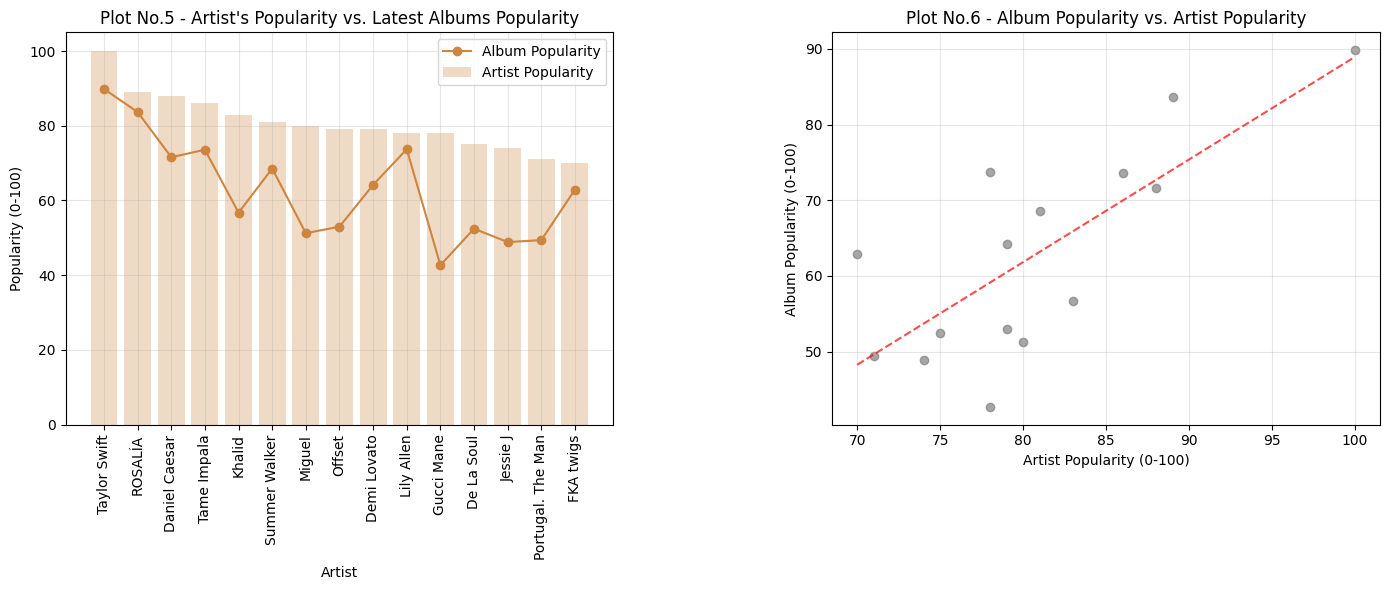

In [466]:
#sort by artist popularity
art_df = art_df.sort_values("artist_popularity", ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Artist Popularity vs Album Popularity (per artist)
ax1 = axs[0]
x = art_df["artist"]

ax1.bar(x, art_df["artist_popularity"],
        alpha=0.3, color="peru", label="Artist Popularity")
ax1.plot(x, art_df["pop_avg"],
         marker="o", color="peru", label="Album Popularity")

ax1.set_xlabel("Artist")
ax1.set_ylabel("Popularity (0-100)")
ax1.tick_params(axis="x", rotation=90)
ax1.set_title("Plot No.5 - Artist's Popularity vs. Latest Albums Popularity")
ax1.legend()
ax1.grid(alpha=0.3)

#Right album: Album Popularity vs Artist Popularity (scatter)
ax2 = axs[1]

ax2.scatter(art_df["artist_popularity"], art_df["pop_avg"],
           alpha=0.7, color="grey")


ax2.set_xlabel("Artist Popularity (0-100)")
ax2.set_ylabel("Album Popularity (0-100)")
ax2.set_title("Plot No.6 - Album Popularity vs. Artist Popularity")

# regression line to show the trend
z = np.polyfit(art_df["artist_popularity"], art_df["pop_avg"], 1)
p = np.poly1d(z)
x_line = np.linspace(art_df["artist_popularity"].min(),
                    art_df["artist_popularity"].max(), 100)
ax2.plot(x_line, p(x_line), linestyle="--", color="red", alpha=0.7)

ax2.grid(alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.show()

##### Case Study: Lily Allen’s “West End Girl” 

To evaluate how individual albums perform relative to both internal structure and artist visibility, we conduct a focused case study using two complementary metrics visualised in Plot no. 7 and Plot no. 8.

**Plot no. 7** examines each album’s internal consistency by comparing the mean popularity of its tracks to the $\frac{\text{Range}}{\text{Mean}}$ ratio, where Range is calculated as: $\max_{\text{popularity in album}} - \min_{\text{popularity in album}}$ - a measure of how dispersed the popularity scores are.
A low $\frac{\text{Range}}{\text{Mean}}$ ratio indicates a cohesive album where all tracks perform similarly well, while a high ratio suggests albums driven by one or two standout hits.

Here, Lily Allen’s album “West End Girl” stands out clearly.
It not only achieves one of the highest mean popularity scores in the entire dataset, but also shows the lowest popularity dispersion. This combination indicates exceptionally uniform listener engagement - a sign that audiences consumed the album as a whole, rather than going back to the same isolated songs.
This reflects the album’s narrative structure - it unfolds like a story with a clear beginning, middle, and end, which encourages listeners to experience it from start to finish.

**Plot no. 8** evaluates how each album performs relative to the artist’s baseline visibility by plotting the ratio:
$$
\frac{\text{Album Popularity}} {\text{Artist Popularity}}
$$

This highlights albums that over-perform or under-perform expectations based on the artist’s existing momentum.

Once again, “West End Girl” ranks first, achieving the highest ratio in the dataset. 
Although we don’t have historical popularity data that would let us measure how each album changed its artist’s momentum, this ratio still provides a useful indication of how well an album performs relative to the artist’s general standing.
At the lower end, artists like Gucci Mane and Miguel show ratios that suggest their new releases didn’t match the success of their past discography.
On the other hand, Lily Allen’s ratio is close to one, meaning her latest album is performing almost as strongly as her overall popularity on Spotify - a sign of a particularly well-received release. Especially for a comeback album, as her last release came out in 2018.


Together, Plot no. 7 and Plot no. 8 reveal a powerful insight:
“West End Girl” is not just a strong album, it is an unusually cohesive project that outperforms the normative trend of its peers and elevates Lily Allen’s overall momentum more than any other release in the dataset.

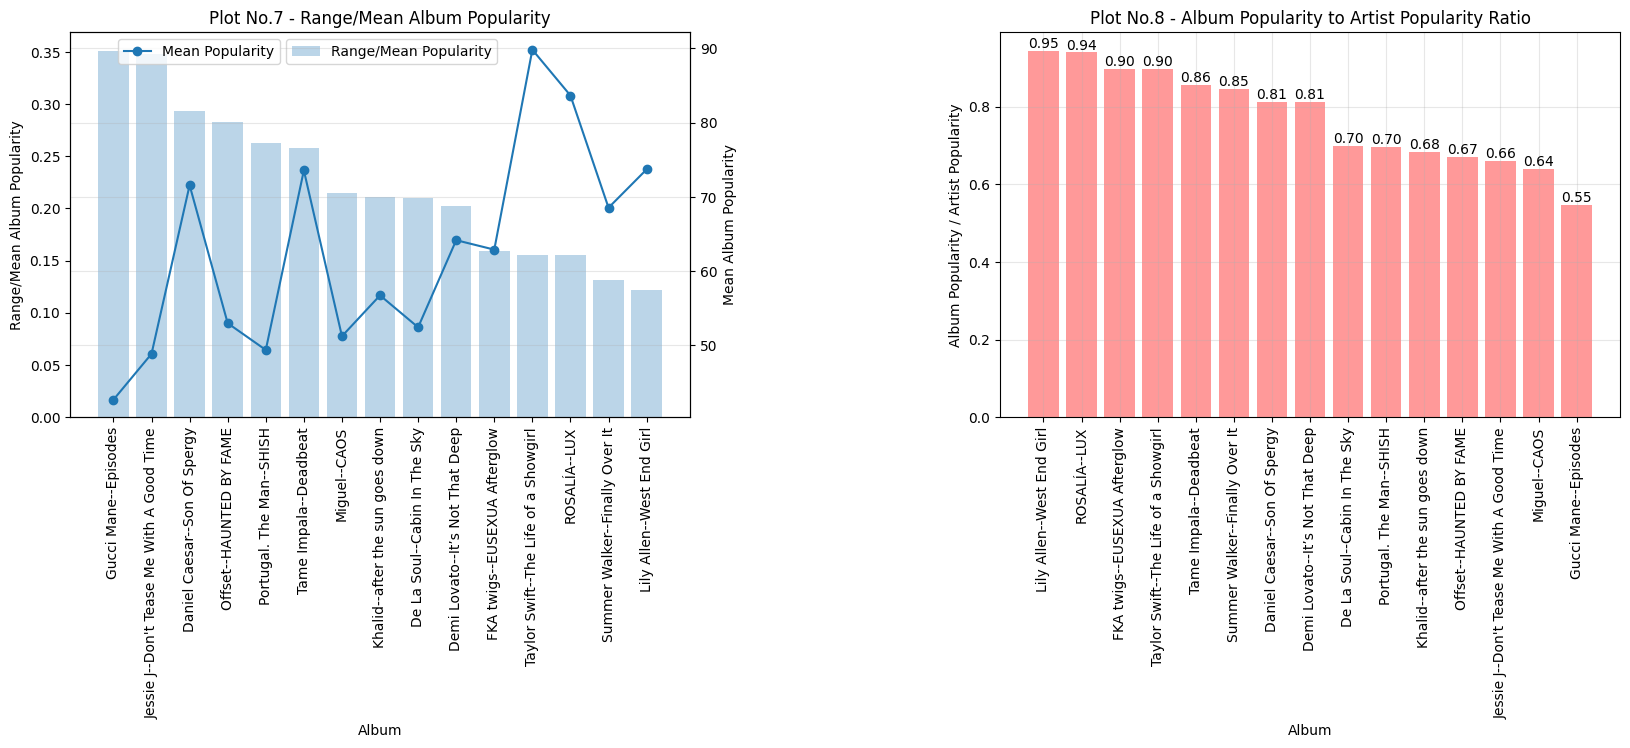

In [467]:
#fig, axs = plt.subplots(2,2, figsize=(14,12))
art_df = art_df.sort_values("range_div_mean", ascending=False)

fig, axs = plt.subplots(1,2, figsize=(20,5))

ax1 = axs[0]

x = art_df["artist_album"]

ax1.bar(x, art_df["range_div_mean"], alpha = 0.3, label = "Range/Mean Popularity")
ax1.tick_params(axis = "x", rotation = 90)
ax1.set_xlabel("Album")
ax1.set_ylabel("Range/Mean Album Popularity")
ax1.set_title("Plot No.7 - Range/Mean Album Popularity")

ax2 = ax1.twinx()
ax2.plot(x, art_df["pop_avg"], marker = "o", label = "Mean Popularity")
ax2.set_ylabel("Mean Album Popularity")

ax1.legend(bbox_to_anchor = (0.7,1))
ax2.legend(bbox_to_anchor = (0.35,1))
plt.grid(alpha = 0.3)

art_df["popularity_ratio"] = art_df["pop_avg"] / art_df["artist_popularity"]
art_df = art_df.sort_values("popularity_ratio", ascending=False)

ax3 = axs[1]
bars = ax3.bar(art_df["artist_album"], art_df["popularity_ratio"], color = "red", alpha = 0.4)

for bar in bars:
    height = bar.get_height()
    ax3.text(
            bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom"
    )
ax3.set_title("Plot No.8 - Album Popularity to Artist Popularity Ratio")
ax3.set_ylabel("Album Popularity / Artist Popularity")
ax3.set_xlabel("Album")
ax3.tick_params(axis="x",rotation=90)
ax3.grid(alpha=0.3)

plt.subplots_adjust(wspace=0.5)
#plt.tight_layout()
plt.show()

## Summery , Conclusion & Restrictions

This project explored the relationship between artists’ long-term audience metrics, their overall popularity on Spotify, and the real-time success of their latest albums. The analysis revealed several meaningful insights, but it is important to note that Spotify’s public API provides limited data: we do not have access to exact stream counts, historical trends, or even a full explanation of how the popularity score is calculated. As a result, all conclusions should be interpreted with caution.

 - First, follower count does not reliably predict an album’s success. It reflects long-term fanbase size and may be influenced by many unrelated factors, making it too vague to measure short-term performance. 

 - However, follower count does show a moderate connection to an artist’s general popularity score - though with many exceptions. A particularly strong album release by a relatively niche artist can quickly elevate their overall popularity, while a weak release by a highly followed artist may not significantly affect their standing.

 - The case study of **Lily Allen** provided the clearest findings. Her new album shows exceptional performance: a high average popularity, minimal variation across tracks, and an album-to-artist popularity ratio close to one. This suggests that **West End Girl** not only succeeded on its own merits but also revitalized an artist whose broader career had been largely dormant in recent years. Its cohesive storytelling structure - built like a narrative with a beginning, middle, and end - encourages full-album listening, which is increasingly rare in today’s single-driven streaming landscape.

Overall, while the insights are compelling, richer data (such as historical popularity and streaming count data) would allow for a deeper and more definitive understanding of album and artist success patterns.